<div align="center"><font size="6">Freeze-Non freeze Products Classifier</font></div>

# 1. The Precios Cuidados Dataset

### Imports

In [1]:
from sklearn.datasets import load_files
from random import randint,shuffle
import matplotlib.pyplot as plt 
import numpy as np
import cv2
import PIL.Image
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array,array_to_img

Using TensorFlow backend.


### Loading the Dataset

In [2]:
# Read the product images from the directory
data_dir  = "../data/preciosclaros_products"

print("Loading dataset from: ", data_dir,"\n")
raw_data = load_files(data_dir)

Loading dataset from:  ../data/preciosclaros_products 



### Exploring the Dataset

In [3]:
# Sklearn packged the images in a dictionary
print("Dataset keys: ",raw_data.keys())

# Reading the information form the sklearn dataset
filenames = raw_data['filenames']
target_classes = raw_data['target']
target_names = raw_data['target_names']
data = raw_data['data']

raw_img_qty = len(filenames)

print("Dataset images qty:", raw_img_qty)
print("Classes qty:", len(target_names))
print("Classes names:", target_names)
print("\n")

print("# Products of each class:")
for c in range(len(target_names)):
    prod_qty = len([p for p in target_classes if p==c])
    print("{}: {} ({}%)".format(str(c)+": "+target_names[c], prod_qty, round(prod_qty/raw_img_qty,2)))
    
raw_img_idx = randint(1,raw_img_qty)
filename = filenames[raw_img_idx]   
img = cv2.imread(filename)

print("\n")
print("Each image shape: ",img.shape)





Dataset keys:  dict_keys(['data', 'filenames', 'target_names', 'DESCR', 'target'])
Dataset images qty: 4685
Classes qty: 2
Classes names: ['fridge', 'non_fridge']


# Products of each class:
0: fridge: 682 (0.15%)
1: non_fridge: 4003 (0.85%)


Each image shape:  (240, 240, 3)


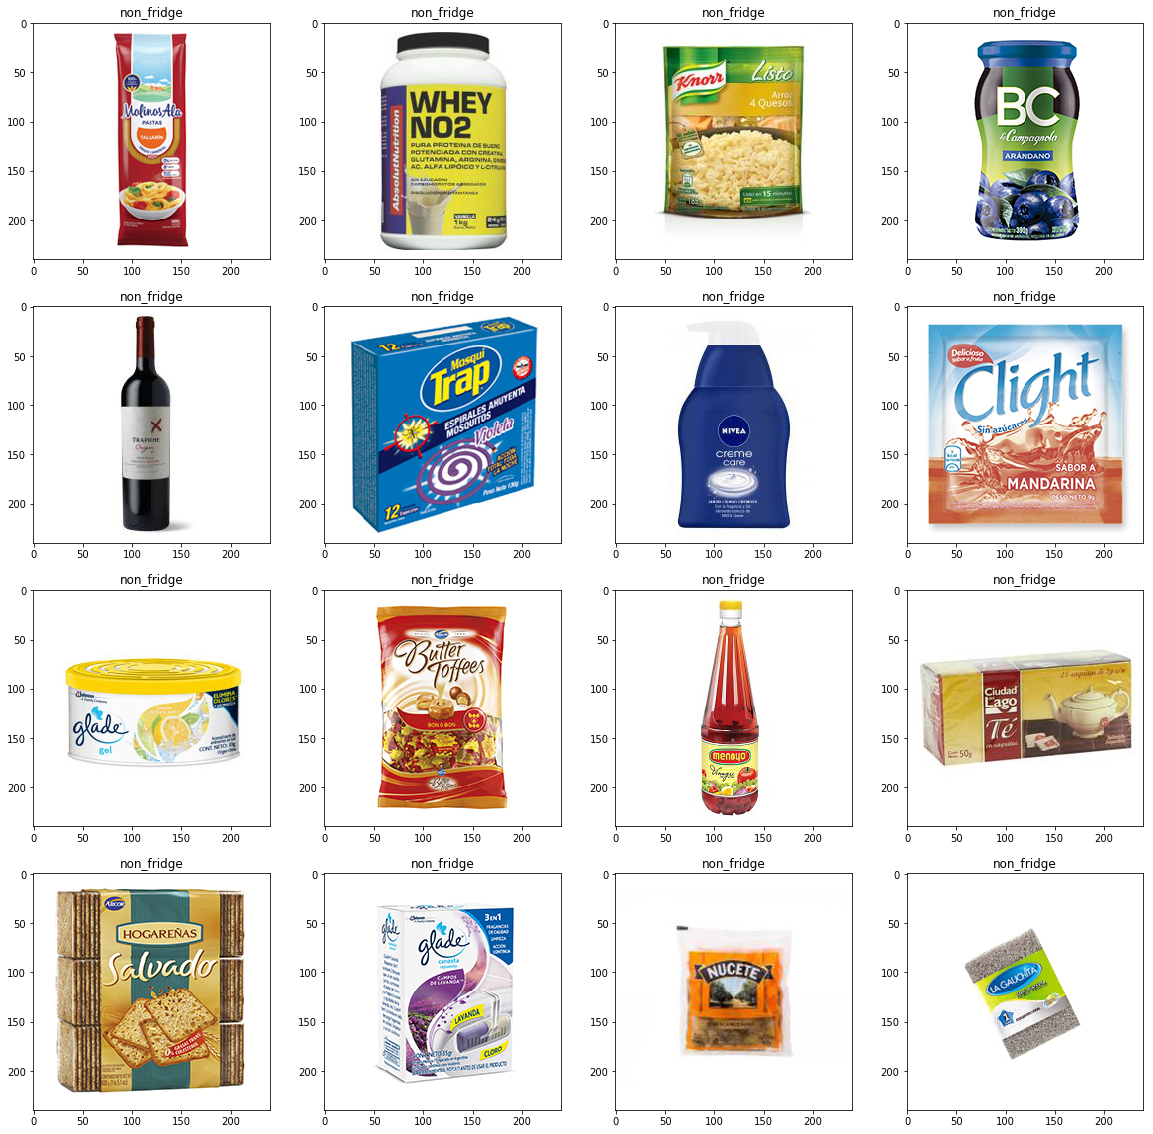

In [4]:
# Dataset images sampling
fig=plt.figure(figsize=(20, 20))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    raw_img_idx = randint(1,raw_img_qty)
    filename = filenames[raw_img_idx]
    target_class = target_classes[raw_img_idx]
    
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    fig.add_subplot(rows, columns, i)
    plt.title(target_names[target_class])
    plt.imshow(img)
plt.show()


# 2. Dataset preparation

### Spliting the dataset

First, I will define which percentage of the data will be destinated to train, validation, and test.

In [5]:
train_pct = 0.75
val_pct = 0.15
test_pct = 0.1

assert(train_pct+val_pct+test_pct==1.0)

Auxiliary methods 

In [6]:
def split_train_val_test(ids, train_pct, val_pct):
    '''
    Splits the ids in train, valid, and test according to the specified percentages.
    
    Input:  ids - set of data indexes
            train_pct - % destinated to the train set
            val_pct - % destinated to the validation set
    
    Output: Tuple (train set, validation set, test set)
            Each component a list of ids
            
    '''
    total = len(ids)

    shuffle(ids)

    train_idx = int(train_pct*total)
    val_idx = int(val_pct*total)


    train_set  = ids[0:train_idx]
    val_set    = ids[train_idx:train_idx+val_idx]
    test_set  = ids[train_idx+val_idx:]
    
    return train_set, val_set, test_set

def merge_sets_and_shuffle(set1, set2):
    '''
    Merges two lists and returns shuffled the result
    '''
    set1 = set1+set2
    shuffle(set1)
    return set1

def get_set_stats(target_set, target_set_fridge, target_set_non_fridge, total):
    '''
    Returns the stats for a set (tuple):
        total
        percentage over all the images
        fridge quantity
        percentage fridge over total
        non-frige qty
        percentage non-fridge over total
    '''
    fridge_qty     = len(target_set_fridge) 
    non_fridge_qty = len(target_set_non_fridge)
    total_set = len(target_set)
    
    pct_total = round(total_set/total,2)
    pct_fridge = round(fridge_qty/total_set,2)
    pct_non_fridge= round(non_fridge_qty/total_set,2)
    
    return total_set, pct_total, fridge_qty, pct_fridge, non_fridge_qty, pct_non_fridge


In [7]:
## The idea is to build the sets keeping the proporsion of each class

# Separates the ids of the images according the class
fridge_ids     = [i for i,p in enumerate(target_classes) if p==0] 
non_fridge_ids = [i for i,p in enumerate(target_classes) if p==1] 

# Divides in sets according the percentage destinated for train, validation, and test set
train_set0, valid_set0, test_set0 = split_train_val_test(fridge_ids,train_pct,val_pct)
train_set1, valid_set1, test_set1 = split_train_val_test(non_fridge_ids,train_pct,val_pct)

# Merges both classes train, valid, and test sets to build a unique train, test, and valid set
train_set_ids = merge_sets_and_shuffle(train_set0, train_set1) 
valid_set_ids = merge_sets_and_shuffle(valid_set0, valid_set1) 
test_set_ids  = merge_sets_and_shuffle(test_set0, test_set1) 

# Priting some stats to see the results
print("Resultant sets stats:")

st = get_set_stats(train_set_ids, train_set0, train_set1, raw_img_qty)
print("Train Set: Total={} ({}%) , Fridge={} ({}%), Non-Frige={} ({}%)".format(*st))

st = get_set_stats(valid_set_ids, valid_set0, valid_set1, raw_img_qty)
print("Valid Set:  Total={} ({}%) , Fridge={} ({}%), Non-Frige={} ({}%)".format(*st))

st = get_set_stats(test_set_ids, test_set0, test_set1, raw_img_qty)
print("Test Set: Total={} ({}%) , Fridge={} ({}%), Non-Frige={} ({}%)".format(*st))


Resultant sets stats:
Train Set: Total=3513 (0.75%) , Fridge=511 (0.15%), Non-Frige=3002 (0.85%)
Valid Set:  Total=702 (0.15%) , Fridge=102 (0.15%), Non-Frige=600 (0.85%)
Test Set: Total=470 (0.1%) , Fridge=69 (0.15%), Non-Frige=401 (0.85%)


### Loading the images and labels (without data augmentation in memory)

In [65]:
def load_images_from_files(ids):
    img_shape = img_to_array(load_img(filenames[0])).shape
    images = np.ndarray(shape=(len(ids),)+img_shape,dtype=float)

    for i, img_nbr in enumerate(ids):
        img = load_img(filenames[img_nbr])  
        x = img_to_array(img)  
        
        images[i] = x
        
    return images
        
def load_labels(ids):
    res =[x for i,x in enumerate(target_classes) if i in ids] 
    labels = np.asarray(res)
    return labels    

In [68]:
reload = False

if reload:
    pre_train_set = load_images_from_files(train_set_ids)
    pre_valid_set = load_images_from_files(valid_set_ids)
    pre_test_set  = load_images_from_files(test_set_ids)

    
pre_train_labels = load_labels(train_set_ids)
pre_valid_labels = load_labels(valid_set_ids)
pre_test_labels  =  load_labels(test_set_ids)


print("-- Pre processed Train dataset --")
print("Dataset shape: ", pre_train_set.shape)
print("Labels shape:", pre_train_labels.shape)

print("-- Pre processed Test dataset --")
print("Dataset shape: ", pre_valid_set.shape)
print("Labels shape:", pre_valid_labels.shape)

print("-- Pre processed Validate  dataset --")
print("Dataset shape: ", pre_test_set.shape)
print("Labels shape:", pre_test_labels.shape)



-- Pre processed Train dataset --
Dataset shape:  (3513, 240, 240, 3)
Labels shape: (3513,)
-- Pre processed Test dataset --
Dataset shape:  (702, 240, 240, 3)
Labels shape: (702,)
-- Pre processed Validate  dataset  --
Dataset shape:  (470, 240, 240, 3)
Labels shape: (470,)


### Define the data transformation to be applied (Data Augmentation)

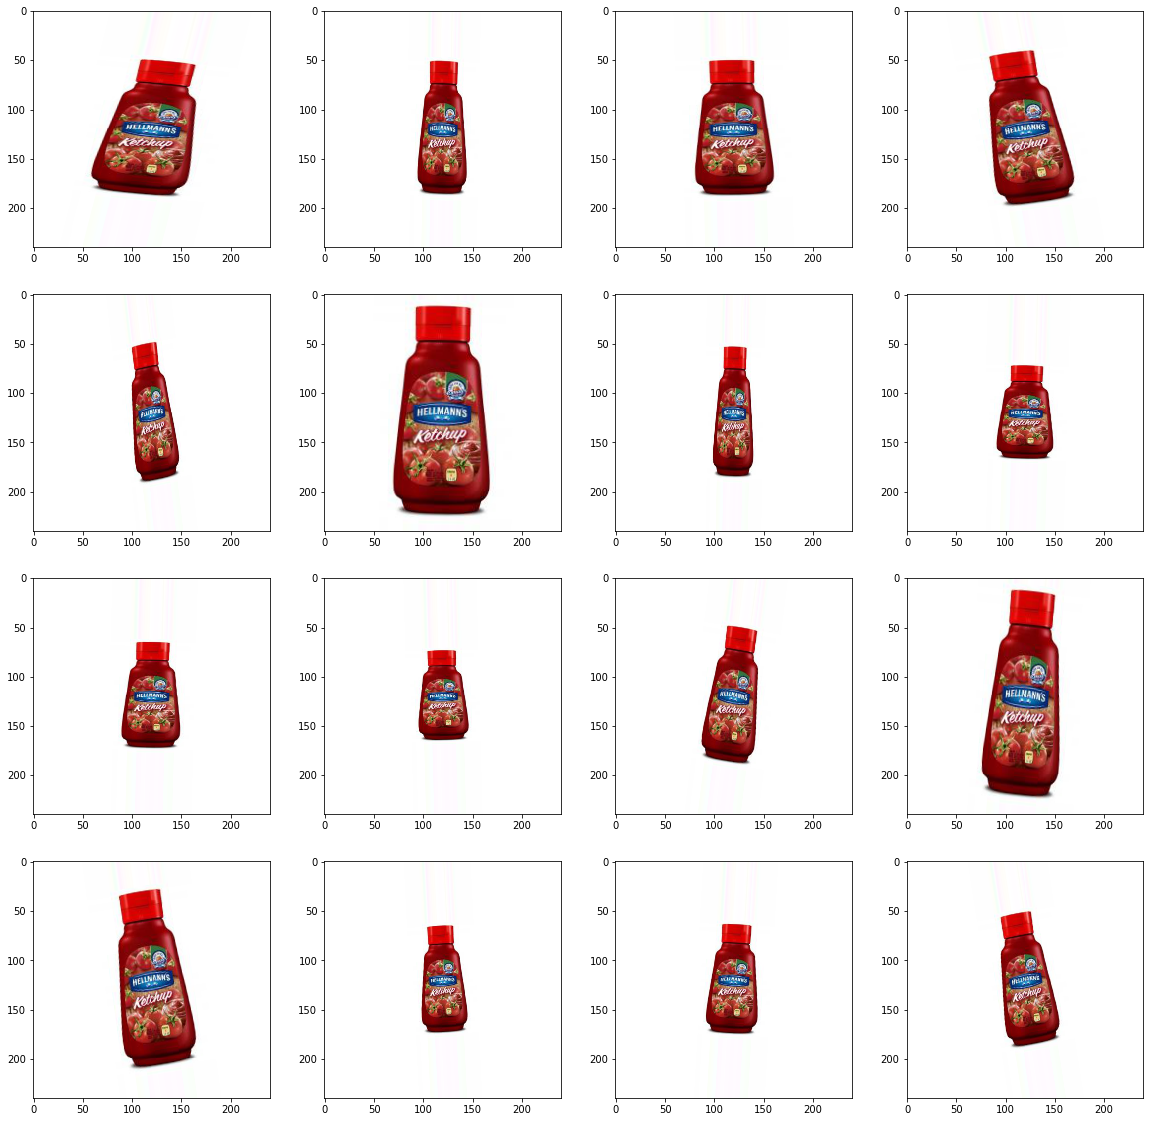

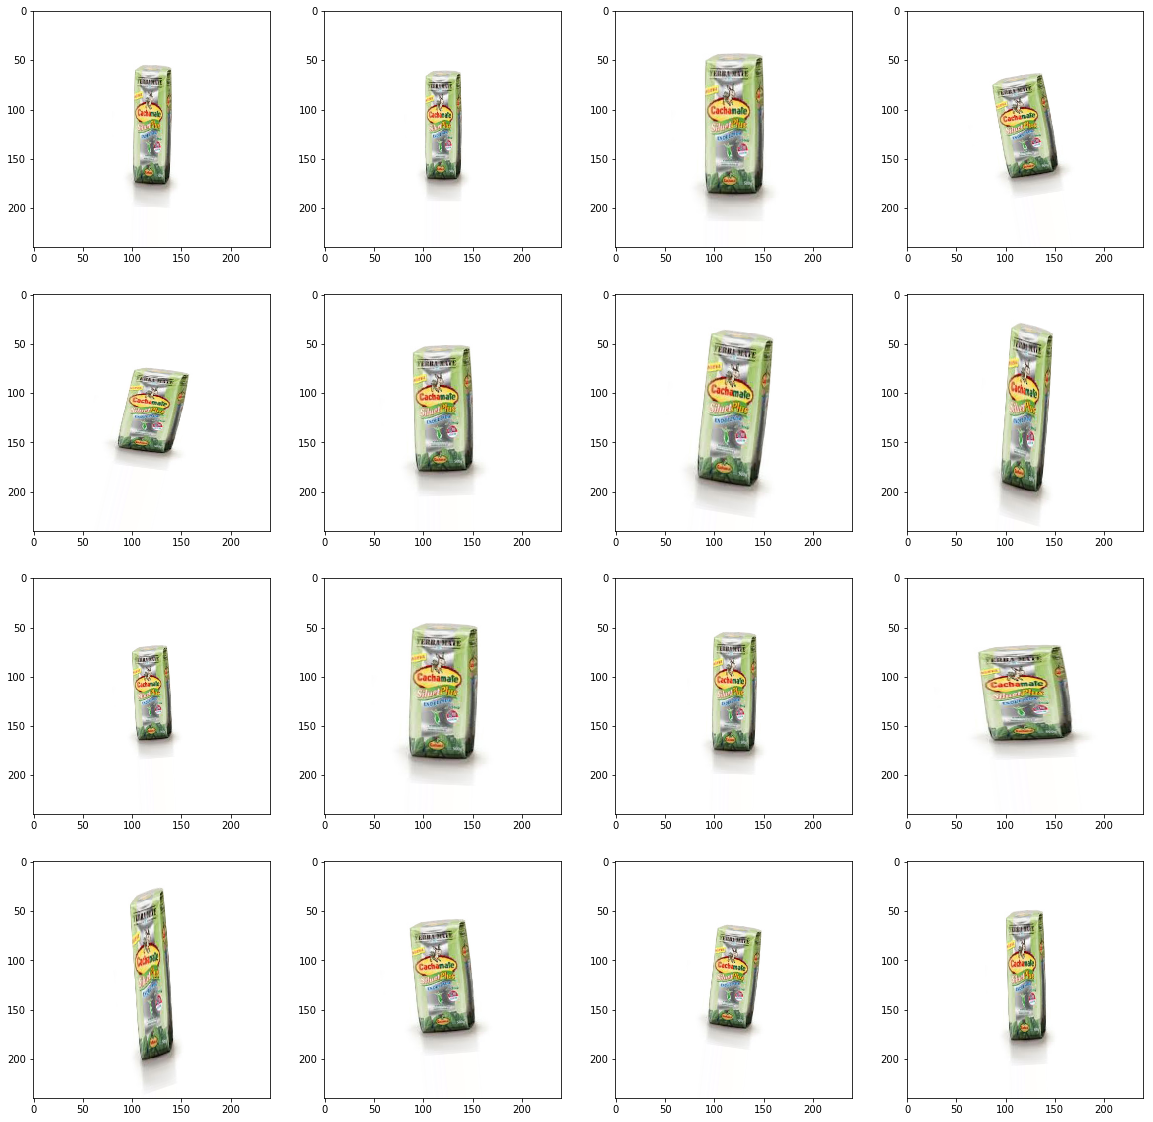

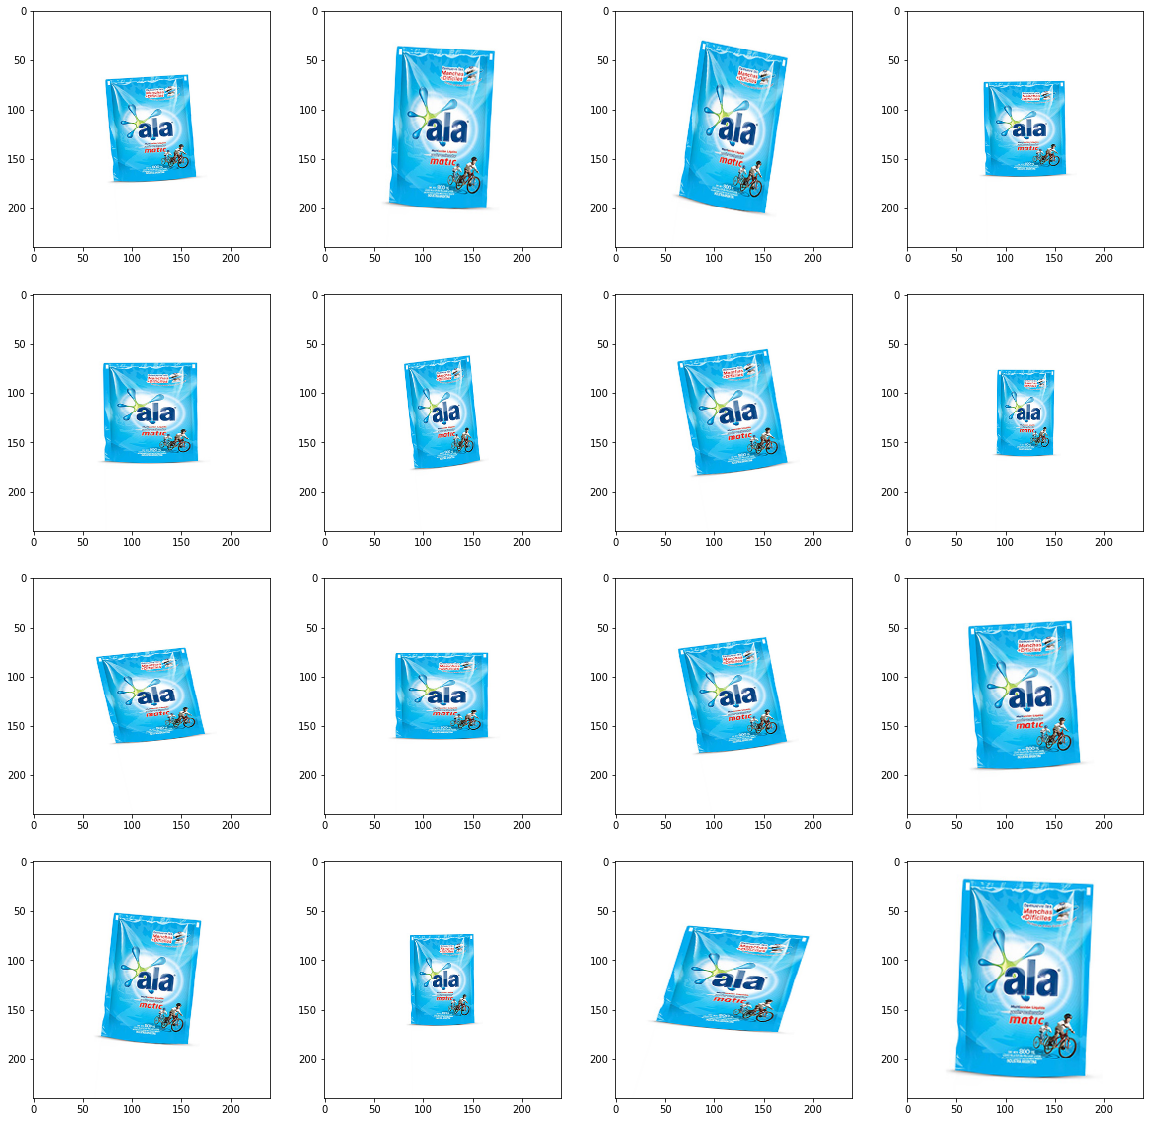

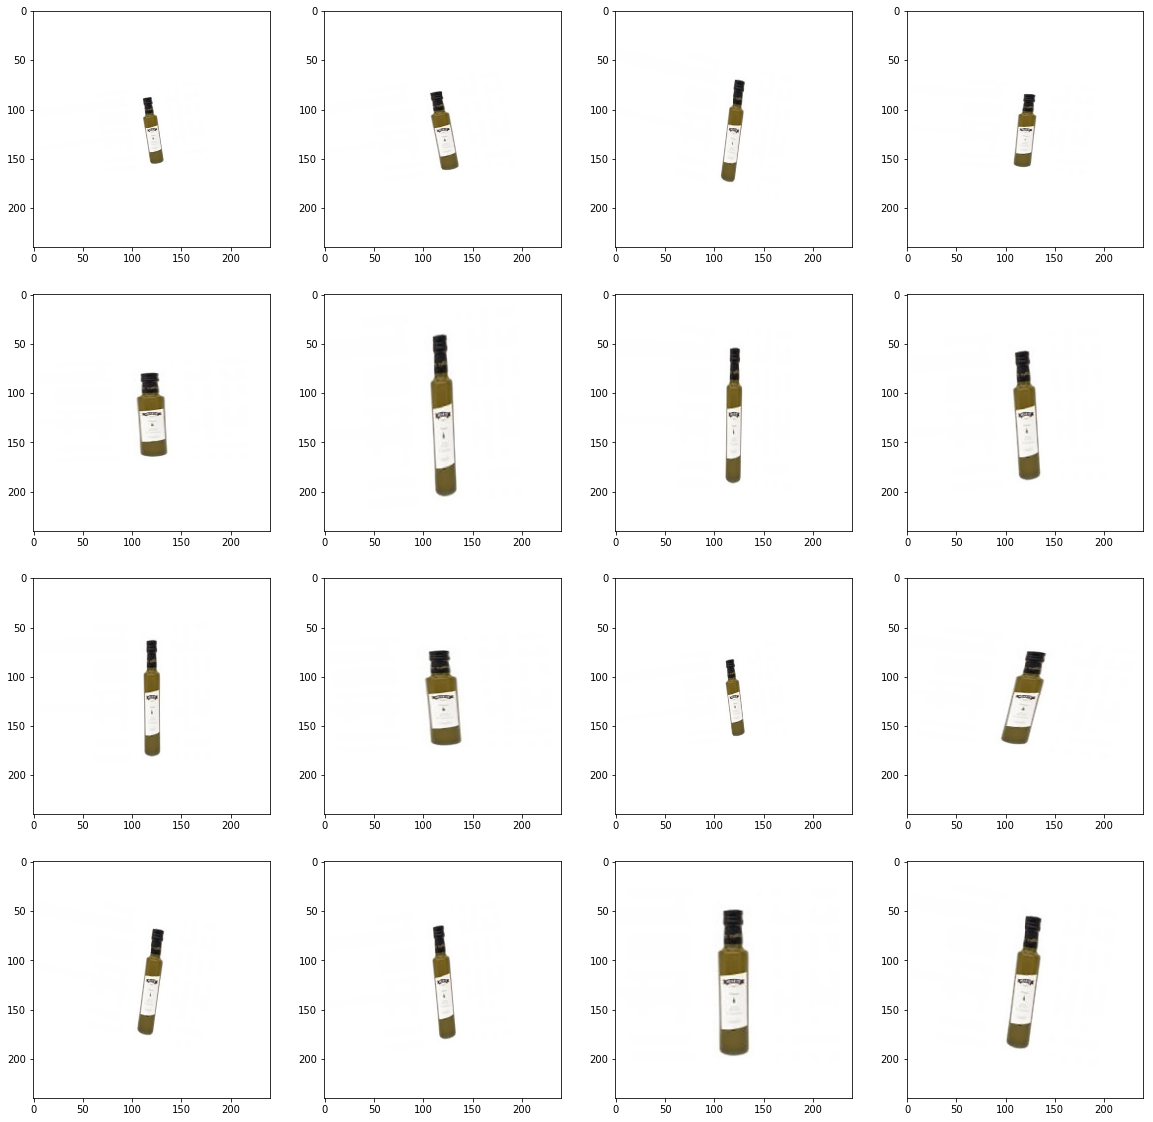

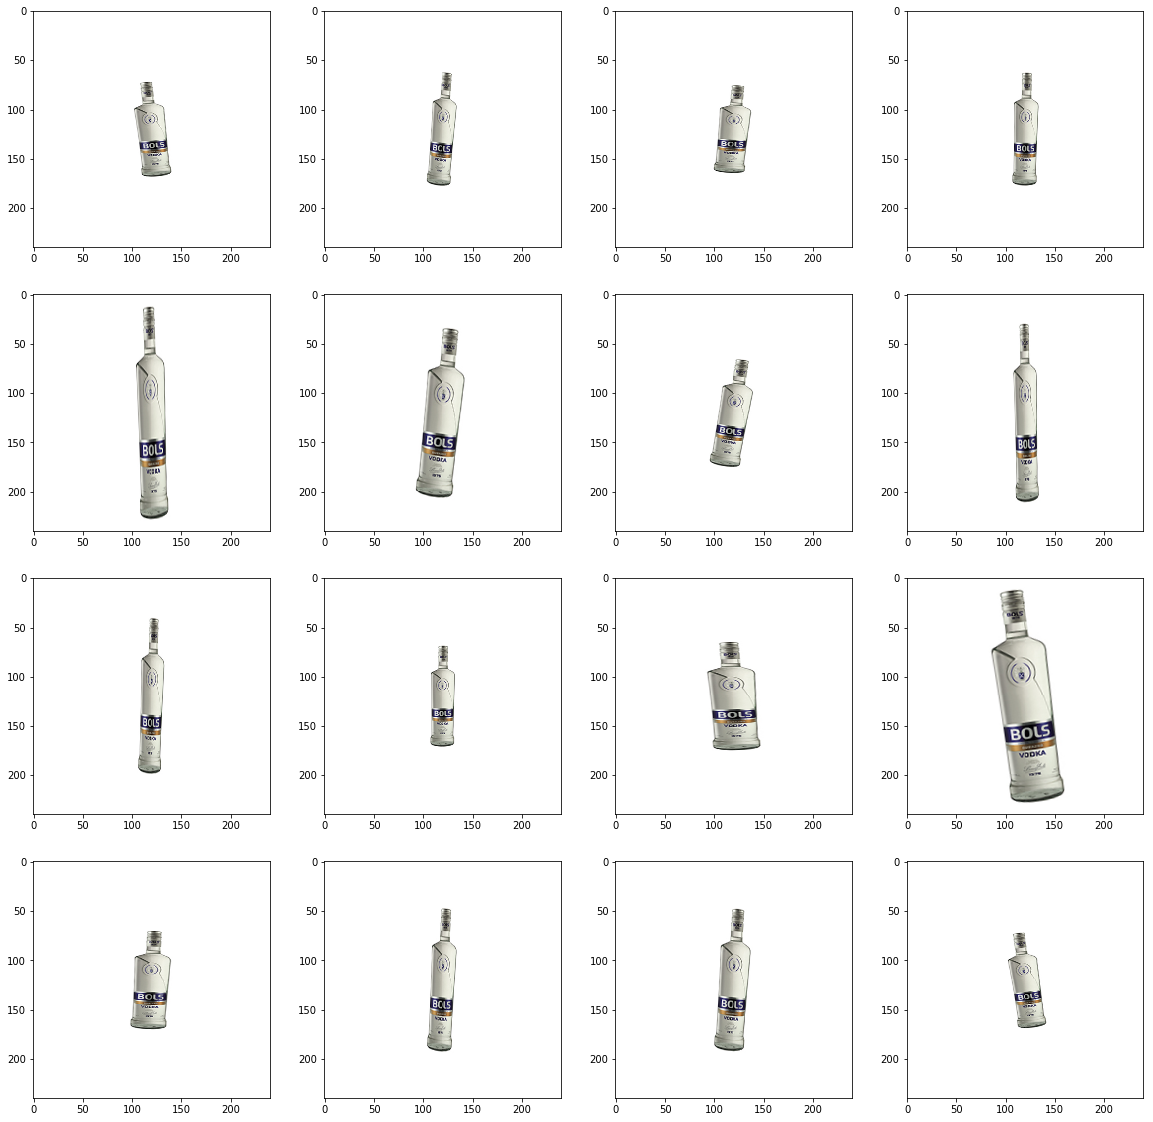

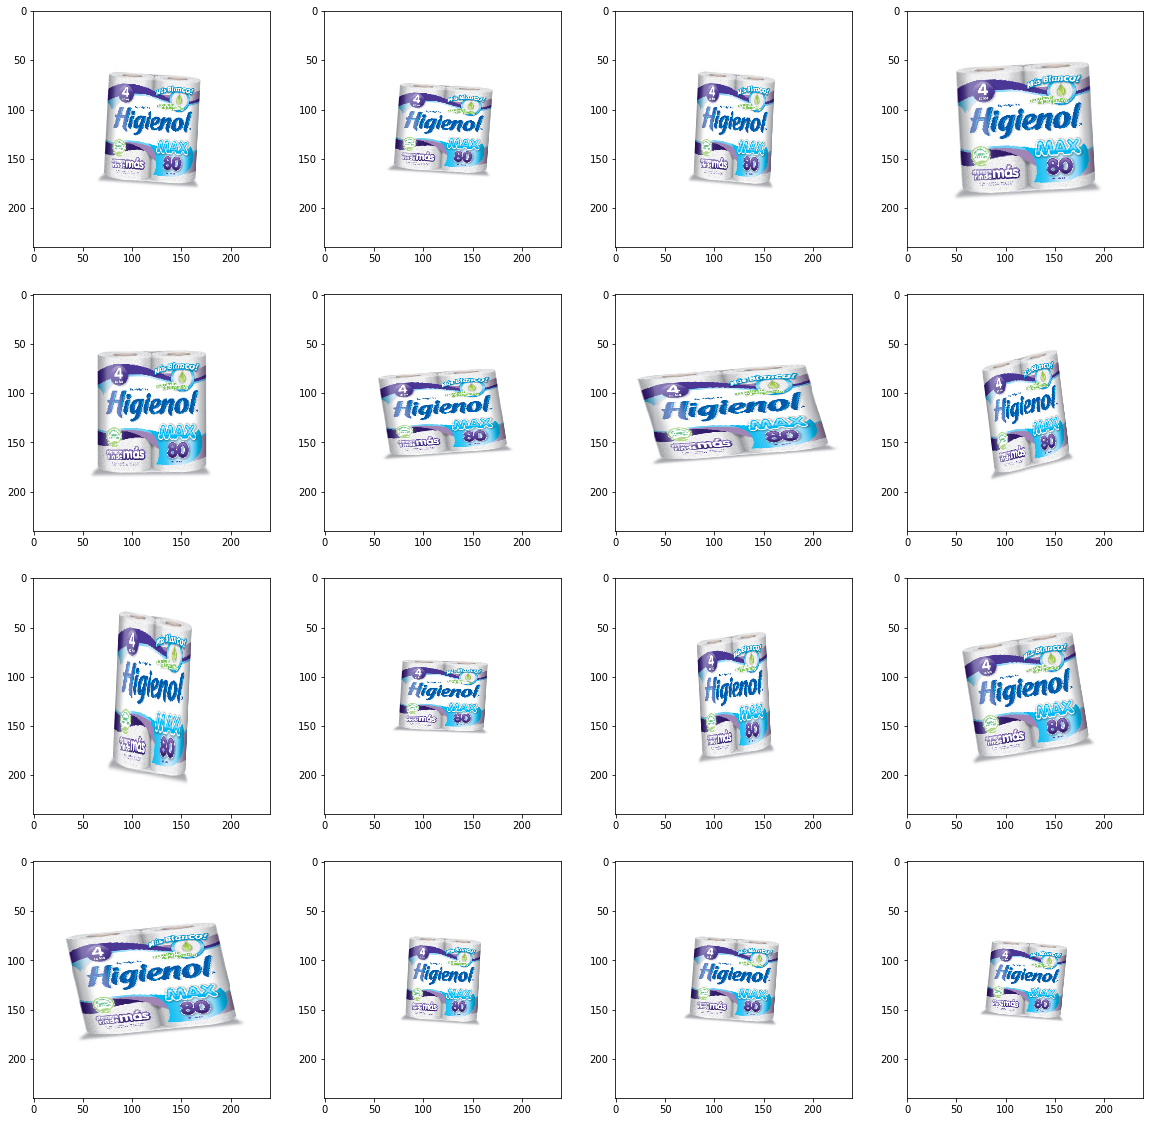

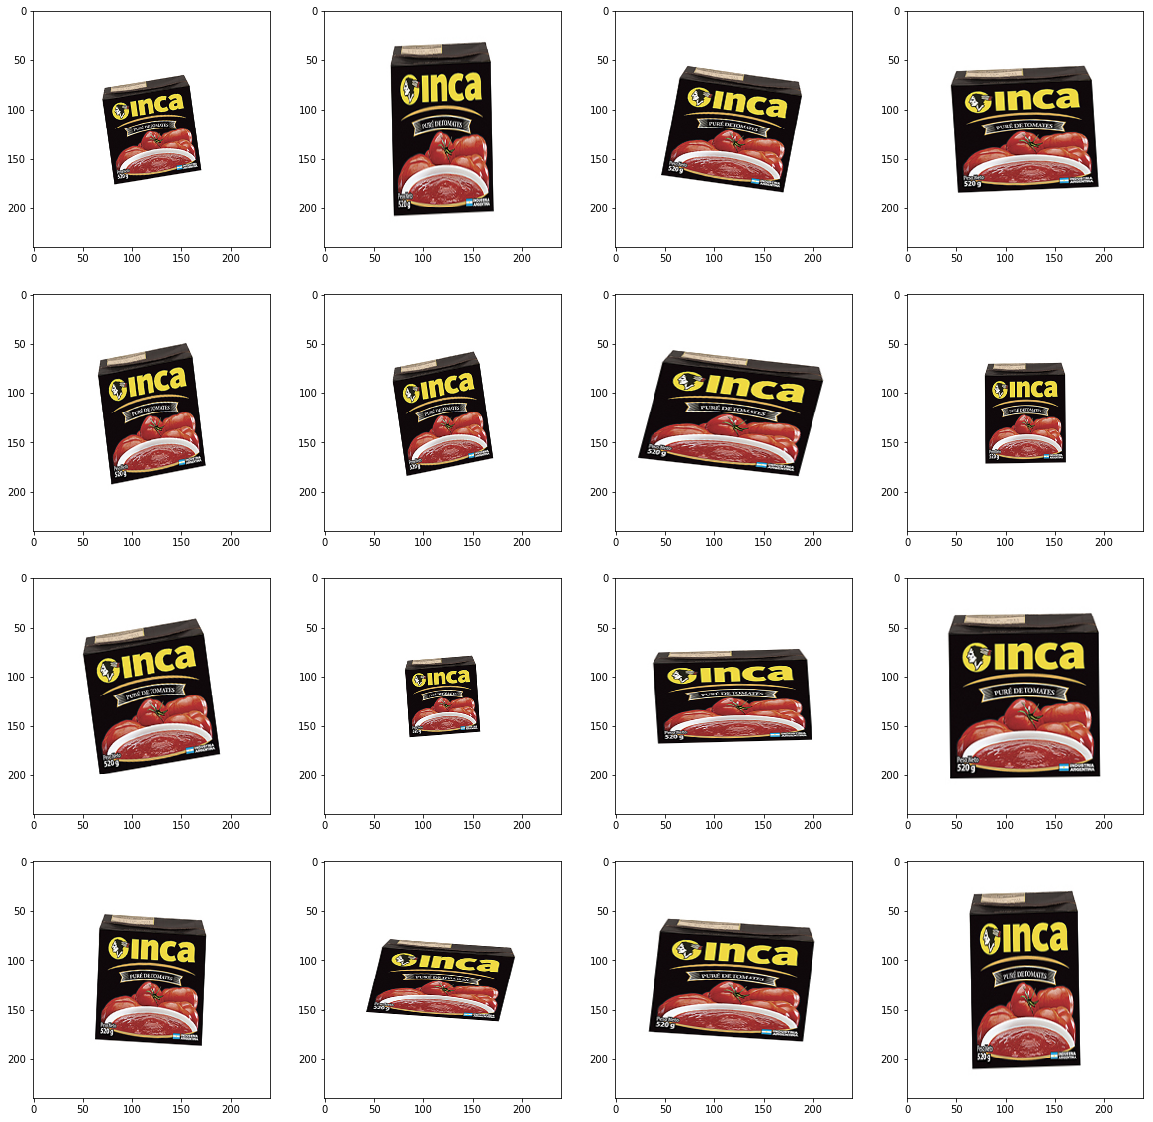

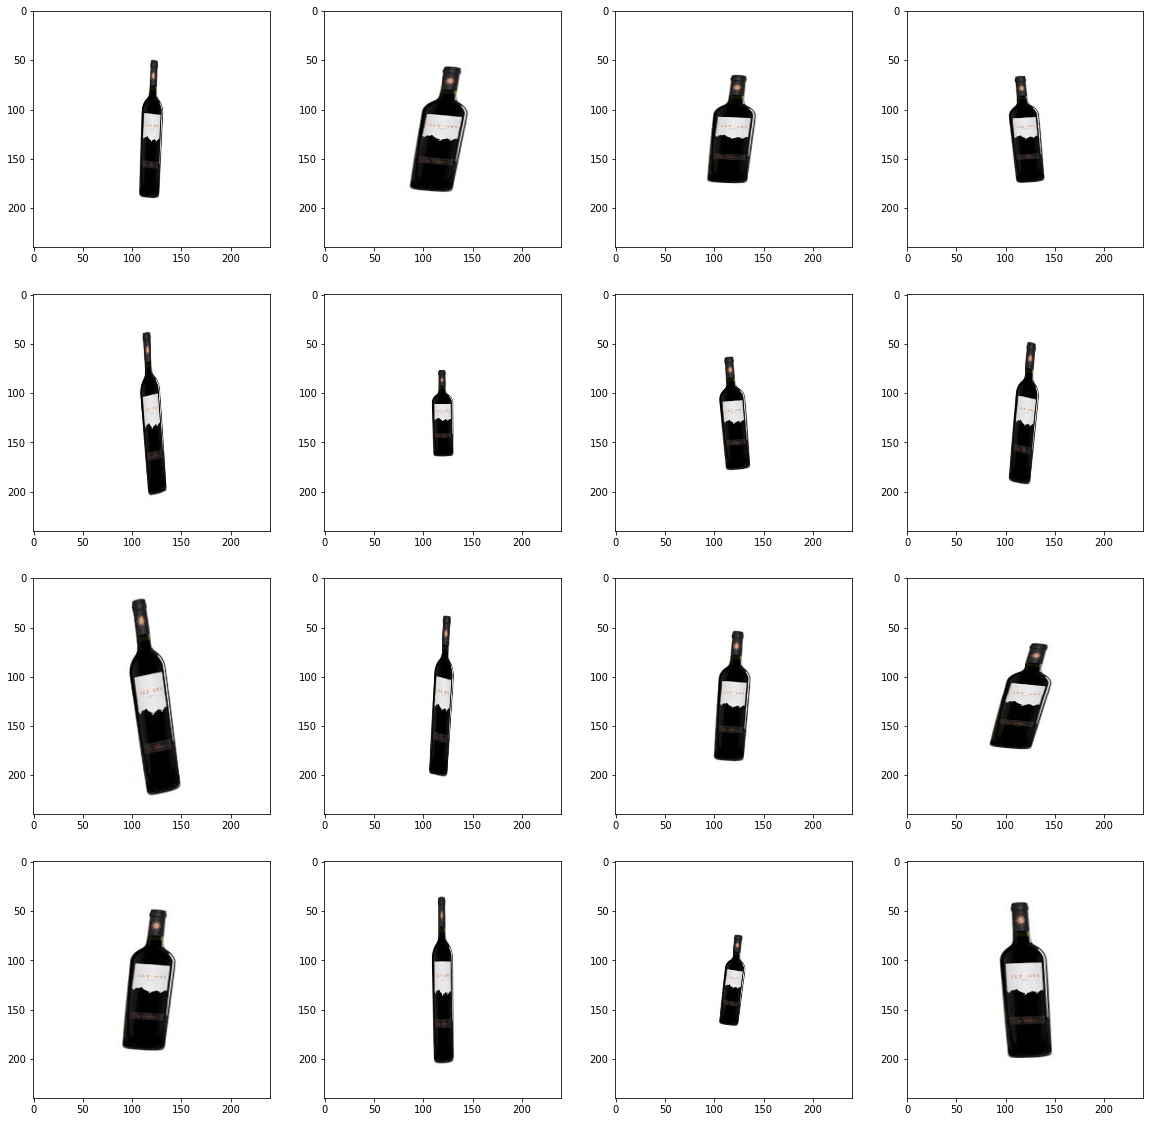

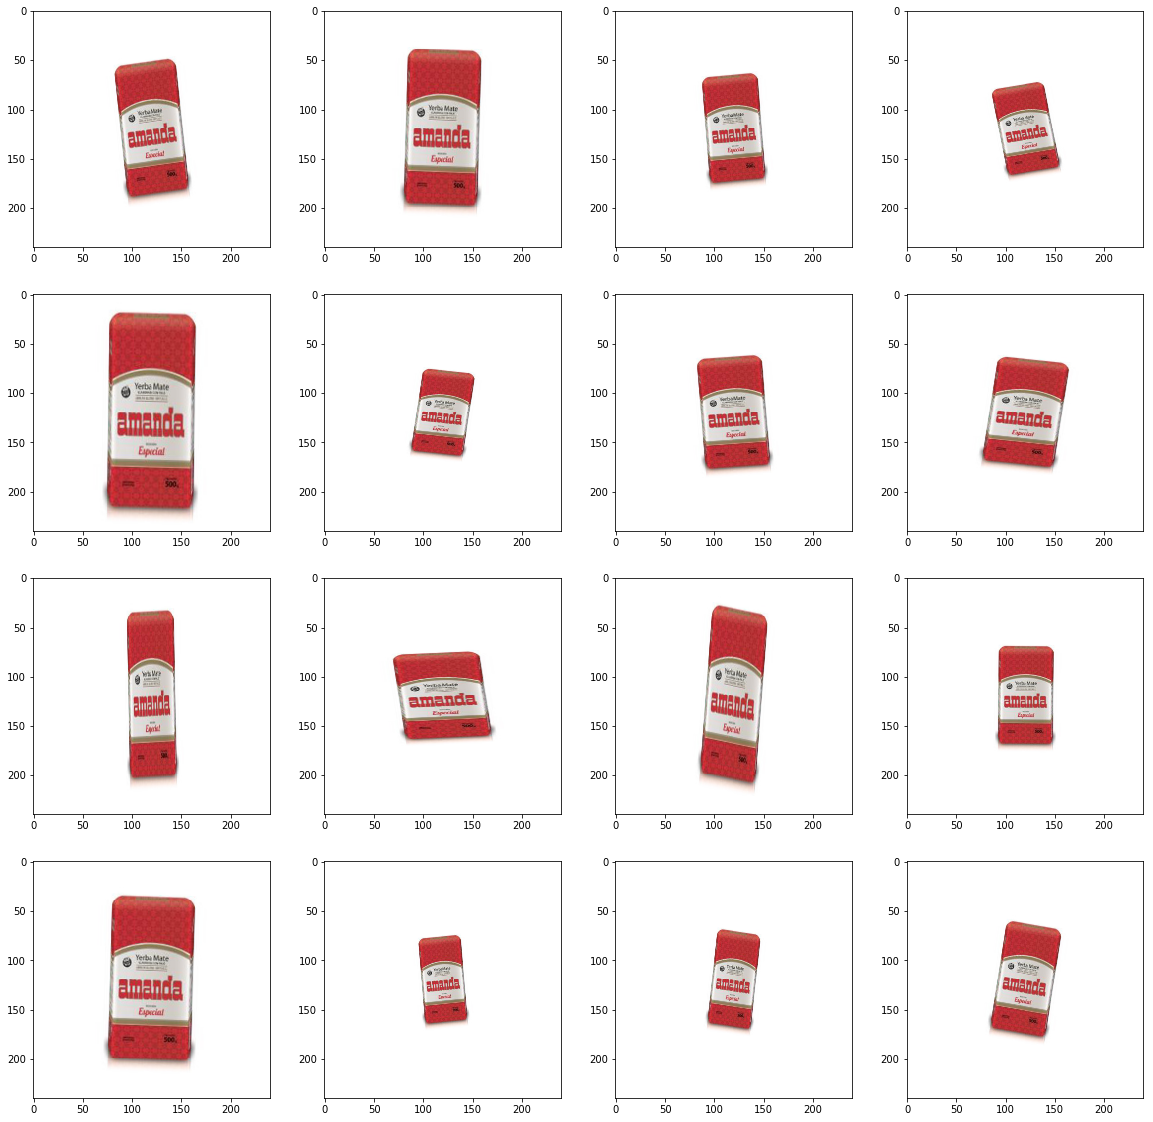

In [46]:
import PIL.Image
datagen = ImageDataGenerator(
        rotation_range=10,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        shear_range=0.5,
        zoom_range=[1,2.5],
        rescale=1./255,
        #horizontal_flip=True,
        fill_mode='nearest')


for i in test_set_ids[1:10]:
    img = load_img(filenames[i])  
    x = img_to_array(img)  
    x = x.reshape((1,) + x.shape) 

    fig=plt.figure(figsize=(20, 20))
    columns = 4
    rows = 4

    j = 0
    for batch in datagen.flow(x, batch_size=1, shuffle=False):
        j += 1
        if j > 16:
            break 
        
        xi = array_to_img(batch[0])
        fig.add_subplot(rows, columns, j)

        plt.imshow(xi)
        
        
    plt.show()   
    

### The data generators creation (Data Augmentation)